# Basic example

We'll search for two months of Sentinel-2 data overlapping our area of interest—in this case, the Santa Fe ski area in New Mexico, USA ([Google maps](https://www.google.com/maps/place/35%C2%B047'24.0%22N+105%C2%B046'48.0%22W/@35.792066,-105.7907579,6065m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d35.79!4d-105.78)).

We use `stackstac` to create an xarray of all the data. From there, it's easy to filter out cloudy scenes from the array based on their metadata, then create a median composite for each month.

In [1]:
import stackstac
import satsearch

In [2]:
lon, lat = -105.78, 35.79

We use `satsearch` to find the relevant STAC (Spatio-Temporal Asset Catalog) items. These basically provide metadata about the relevant scenes, and links to their data.

We'll use element84's search endpoint to look for items from the `sentinel-s2-l2a-cogs` collection on AWS.

In [3]:
%%time
items = satsearch.Search(
    url="https://earth-search.aws.element84.com/v0",
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-04-01/2020-05-01"
).items()
len(items)

CPU times: user 44.9 ms, sys: 6.67 ms, total: 51.5 ms
Wall time: 4.5 s


13

Use `stackstac` to turn those STAC items into a lazy xarray. Using all the defaults, our data will be in its native coordinate reference system, at the finest resolution of al the assets.

In [4]:
%time stack = stackstac.stack(items)

CPU times: user 49.3 ms, sys: 2.18 ms, total: 51.4 ms
Wall time: 50.2 ms


In [5]:
stack

,Array,Chunk
Bytes,213.15 GB,8.39 MB
Shape,"(13, 17, 10980, 10980)","(1, 1, 1024, 1024)"
Count,27304 Tasks,26741 Chunks
Type,float64,numpy.ndarray


Well, that's really all there is to it. Now you have an xarray DataArray, and you can do whatever you like to it!

Here, we'll filter out scenes with >20% cloud coverage (according to the `eo:cloud_cover` field set by the data provider).
Then, pick the bands corresponding to red, green, and blue, and use xarray's `resample` to create 1-month median composites.

In [6]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
rgb = lowcloud.sel(band=["B04", "B03", "B02"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [7]:
monthly

,Array,Chunk
Bytes,5.79 GB,8.39 MB
Shape,"(2, 3, 10980, 10980)","(1, 1, 1024, 1024)"
Count,46323 Tasks,726 Chunks
Type,float64,numpy.ndarray


So we don't pull all ~200 GB of data down to our local machine, let's slice out a little region around our area of interest.

We convert our lat-lon point to the data's UTM coordinate reference system, then use that to slice the `x` and `y` dimensions, which are indexed by their UTM coordinates.

In [8]:
import pyproj
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000  # meters

In [9]:
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-9918e037162926aaa5ec5d240d1a9174' (time: 2, band: 3, y: 400, x: 400)>
dask.array<getitem, shape=(2, 3, 400, 400), dtype=float64, chunksize=(1, 1, 387, 317), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * time                        (time) datetime64[ns] 2020-04-01 2020-05-01
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 4.275e+05 4.275e+05 ... 4.315e+05
  * y                           (y) float64 3.963e+06 3.963e+06 ... 3.959e+06
    constellation               <U10 'sentinel-2'
    instruments                 <U3 'msi'
    ...                          ...
    sentinel:utm_zone           int64 13
    sentinel:sequence           <U1 '0'
    sentinel:valid_cloud_cover  bool True
    sentinel:grid_square        <U2 'DV'
    gsd                         int64 10
    title                       (band) object 'Band 4 (red)' ... 'Band 2 (blue)'
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [10]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[########################################] | 100% Completed | 42.4s


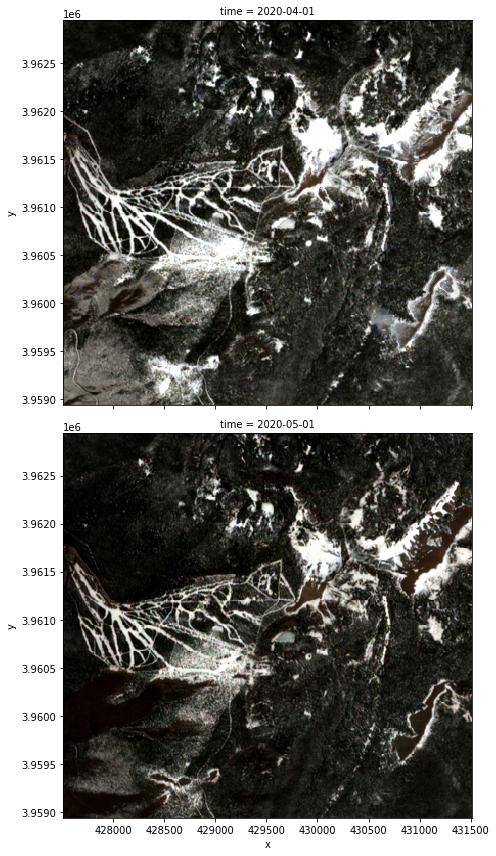

In [11]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6)